# Complexity Reduction
In this notebook, we will introduce the "Complexity Reduction Framework" implemented in PyBigDFT. BigDFT is able to perform calculations on systems composed of thousands of atoms using its linear scaling mode. However, large systems are complex, so it is difficult to use the results of a calculation to gain real insight into the source of a system's emergent properties. Here we will present an analysis technique aimed at understanding large systems. This technique is able to partition systems into well defined fragments and described their interaction.

## Setup Calculation
For our example molecule, we will use a hydrocarbon in complex with Hydrogen Bromide.

In [1]:
istr = """55

O         0.09091579259384   -2.62302675846147   -0.23698714625486
O        -5.19702260261371    0.92740650346888    1.33288276680940
O         1.84758552234076    2.28470179911684   -0.90675217406789
C        -3.32544717693743    1.38496948833948   -0.22443415282365
C         3.71473540115228    1.26014009647345    0.36463564735587
C        -3.26205063592829   -0.09641808280367   -0.63643212176439
C         3.54032722938128   -0.14475964092600   -0.24456698295954
C        -2.29939656374877   -0.96199433259617    0.17146613140677
C         2.48052925426671   -1.02764650758960    0.41192507886761
C        -3.93587971802686    1.53274384650394    1.18416076980164
C         2.39099272097220    2.05419247137115    0.36528060996202
C        -2.28489628096863   -2.40013508890942   -0.34998768402716
C         2.47403876401085   -2.43094708511636   -0.19701846013086
C        -4.20814415411417    2.11994977097899   -1.24235964092461
C        -1.93954527854349    2.03265799239653   -0.22528359655032
C         4.73576593359962    2.02178674786078   -0.48613865761300
C         4.22516453004188    1.16642188507227    1.80395911036070
C        -1.11865085463728   -3.19790501338646    0.22288130094403
C         1.26345634728166   -3.23747531627529    0.26221245903588
H        -4.26504326476884   -0.52036071478215   -0.54718808088864
H        -2.97265394478675   -0.14113524122091   -1.68900210235376
H         3.30314178980041   -0.03946204365438   -1.30649304364255
H         4.50364224971628   -0.65770438719098   -0.18397516715100
H        -1.29219512754936   -0.55218886324925    0.10385536017797
H        -2.59177987221251   -0.96906545460454    1.22199683002862
H         2.66975681248205   -1.11213010642239    1.48285077520664
H         1.49172218908717   -0.58614348427195    0.28378214475355
H        -3.29493411302273    1.04999013791205    1.92439180886178
H        -3.99291485698793    2.60236071212714    1.43622961756284
H         1.65901513106511    1.55504805854778    1.01739355006917
H         2.57895203853381    3.04848854833116    0.77923039984636
H        -2.20529723862695   -2.39815818974517   -1.43927808203638
H        -3.21530254529462   -2.90428732153206   -0.08631325512624
H         2.46250261727747   -2.36408177130871   -1.28647090918977
H         3.37850462359344   -2.96797431348523    0.09226203769948
H        -4.37995103107021    3.14879143626930   -0.93103678496045
H        -5.17051370272961    1.62462165057729   -1.36389638748829
H        -3.71918277998774    2.13711358459843   -2.21328273297581
H        -1.32721193122286    1.65878324151920    0.59081778965303
H        -1.42833893379782    1.83854154389236   -1.16447558972666
H        -2.02759166453779    3.10990126850614   -0.10616887570858
H         4.33699435460836    2.19389544132800   -1.48287745315019
H         5.66293633106054    1.45947338576255   -0.57051900996823
H         4.95586037124104    2.98788292471151   -0.03868363668993
H         3.48443415686091    0.71383190173204    2.45878426322154
H         5.13458061496666    0.57109688190627    1.84466382333066
H         4.44866250344917    2.15857783169804    2.18905046858847
H        -1.13858756701479   -3.17274880153684    1.32180909550153
H        -1.17110331206855   -4.24900642525913   -0.09783887033246
H         1.32274058609897   -4.27239245864701   -0.10661243159111
H         1.22003484130296   -3.26728537466147    1.36046655913542
H        -5.80354378630534    1.34249192294346    0.71051043746892
H         1.62672552750824    1.44111023384375   -1.31898623328707
Br        0.25086948567867   -0.62155359209443   -2.70733839165427
H         0.13659121753688   -1.55598493804212   -1.64710118055979"""

In [2]:
from BigDFT.IO import read_xyz
from io import StringIO
sys = read_xyz(StringIO(istr))

Visualize the system.

In [3]:
from BigDFT.Visualization import get_atomic_colordict
sys.display(colordict=get_atomic_colordict(sys))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Perform a BigDFT calculation on this system.

In [6]:
from BigDFT.Calculators import SystemCalculator
code = SystemCalculator(skip=True, verbose=False)

In [7]:
from BigDFT.Inputfiles import Inputfile
inp = Inputfile()
inp.set_xc("PBE")
inp.set_hgrid(0.37)
inp["import"] = "linear"

In [9]:
log = code.run(sys=sys, input=inp, name="hcb", run_dir="work")

## BigDFTool
For post-processing of BigDFT results, we have a special class called the `BigDFTool`.

In [10]:
from BigDFT.PostProcessing import BigDFTool
tool = BigDFTool()

One thing it can do is read in the matrices that were produced by a calculation. To start, let's read in the matrix `KxS`, which is the product of the Density and Overlap matrix. You can think of this as the Mulliken representation of the density matrix. Load it in and visualize.

In [11]:
kxs = tool.get_matrix_kxs(log)

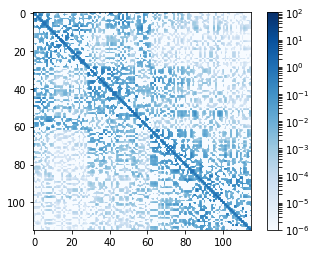

In [12]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import SymLogNorm

fig, axs = plt.subplots(1, 1)
im = axs.imshow(kxs.todense(), # kxs is a sparse matrix when read in
                norm=SymLogNorm(1e-6, vmin=1e-6, vmax=1e2, base=10),
                cmap=cm.Blues) 
_ = fig.colorbar(im)

As we mentioned, the density matrix is idempotent. Using the Mulliken basis, this is verified in practice as:

In [13]:
from numpy import trace
dmat = 0.5 * kxs.todense()
print(trace(dmat.dot(dmat) - dmat))

-4.730411208075935e-06


In the linear scaling mode of BigDFT, we represent the Kohn-Sham orbitals in a basis of in-situ optimized, atom centered support functions. This means we can nominally assign a given basis function (and thus matrix row/column) to a given atom. The `BigDFTool` can give us that information.

In [14]:
fidx = tool.get_frag_indices(sys, log)
print(fidx["ATM:0"])

[35, 36, 37, 38]


Currently our system is fragmented into atoms. These atoms themselves are not good fragments, as we can see be examining the idempotency of the matrix associated with a given atom.

In [15]:
submat = kxs[:,fidx["ATM:0"]]
submat = 0.5*submat[fidx["ATM:0"],:].todense()
print(trace(0.5*submat.dot(0.5*submat) - 0.5*submat))

-0.9321851812197782


This is because we are neglecting the off diagonal terms of the matrix, that connect together the subportions of the system.

In [16]:
from scipy.sparse.linalg import norm
submat = kxs[:,fidx["ATM:0"]]
submat = submat[fidx["ATM:11"],:]
print(norm(submat))

0.12078713103774148


## Purity and Bond Order
The `BigDFTool` has convenient routines for computing the purity values and fragment bond orders, so you don't have to manipulate the matrix yourself. When combined with a dictionary of the number of electrons in a fragment, we can construct a `FragmentView`.

In [17]:
from BigDFT.Systems import FragmentView
p = tool.run_compute_purity(sys, log)  # The "Fragment Purity"
b = tool.fragment_bond_order(sys, list(sys), list(sys), log)  # The"Fragment Bond Order"
c = {k: sum(at.nel for at in v) for k, v in sys.items()}  # The number of electrons
view = FragmentView(p, b, c)

In [18]:
print(view.purities["ATM:0"])

-0.1720527266261184


From the auto-fragment procedure we will build a new system from the information stored in this fragment view.

In [19]:
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment
fsys = System()

lookup, _ = tool.fragment_small_molecule(sys, view, cutoff=0.05, seed=0)

for i, v in enumerate(lookup.values()):
    fsys["FRA:"+str(i)] = Fragment()
    for fid in v:
        fsys["FRA:"+str(i)].extend(sys[fid])

In [20]:
from BigDFT.Visualization import get_colordict
cdict = get_colordict(fsys, colorcode="Dark2")
fsys.display(colordict=cdict)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

If we compute the purity values associated with this new set of fragments, we will find a much different picture.

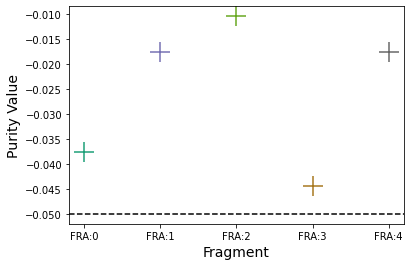

In [21]:
fig, axs = plt.subplots()

for k, v in tool.run_compute_purity(fsys, log).items():
    axs.scatter(int(k.split(":")[1]), v,
                marker="+", color=cdict[k], s=400)
axs.set_ylabel("Purity Value", fontsize=14)
axs.set_xticks(range(len(fsys)))
axs.set_xticklabels(["FRA:"+str(i) for i in range(len(fsys))])
axs.set_xlabel("Fragment", fontsize=14)
_ = axs.axhline(-0.05, linestyle='--', color='k')

Unsurprisingly, the most pure fragment is the Hydrogen Bromide (`FRA:2`) which doesn't have any covalent bonds. The fragmentation is symmetrical, except that someone had to take the oxygen molecule in the middle.

## Interaction Map
The fragment bond order can give us a measure of interaction strength between the two different fragments of our system. We can thus visualize the interactions by translating it into a heatmap.

In [22]:
from numpy import zeros
mat = zeros((len(list(fsys)), len(list(fsys))))
fb = tool.fragment_bond_order(fsys, list(fsys), list(fsys), log)
for f1 in fsys:
    i = int(f1.split(":")[1])
    for f2 in fsys:
        if f1 == f2:
            continue
        j = int(f2.split(":")[1])
        mat[i, j] = fb[f1][f2]

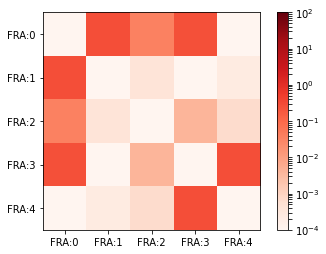

In [23]:
fig, axs = plt.subplots(1, 1)
im = axs.imshow(mat, norm=SymLogNorm(1e-6, vmin=1e-4, vmax=1e2, base=10),
                cmap=cm.Reds) 
axs.set_xticks(range(len(fsys)))
axs.set_xticklabels(["FRA:"+str(i) for i in range(len(fsys))])
axs.set_yticks(range(len(fsys)))
axs.set_yticklabels(["FRA:"+str(i) for i in range(len(fsys))])
_ = fig.colorbar(im)

The interaction between `FRA:2` and `FRA:0` seems worth highlighting. `FRA:0` contains the oxygen from the center of our hydrocarbon. The interaction between it and the acid (which is looking to cleave the bond) is identified correctly by our framework.

## Exercise: Application to Protein
`1UAO` is a small, de-novo protein, made up of just 10 amino acids. Let's load it in and perform some tests on this system.

In [24]:
istr = """ATOM      1  N   GLY     1      -6.778  -1.424   4.200  0.2943  1.5500       N  
ATOM      2  H1  GLY     1      -6.601  -2.405   4.033  0.1642  1.3000       H  
ATOM      3  H2  GLY     1      -7.638  -1.318   4.718  0.1642  1.3000       H  
ATOM      4  H3  GLY     1      -6.011  -1.042   4.735  0.1642  1.3000       H  
ATOM      5  CA  GLY     1      -6.878  -0.708   2.896 -0.0100  1.7000       C  
ATOM      6  HA2 GLY     1      -7.681  -1.143   2.301  0.0895  1.2000       H  
ATOM      7  HA3 GLY     1      -7.086   0.347   3.075  0.0895  1.2000       H  
ATOM      8  C   GLY     1      -5.557  -0.840   2.138  0.6163  1.7000       C  
ATOM      9  O   GLY     1      -4.640  -1.504   2.579 -0.5722  1.5000       O  
ATOM     10  N   TYR     2      -5.452  -0.212   0.999 -0.4157  1.5500       N  
ATOM     11  H   TYR     2      -6.209   0.350   0.638  0.2719  1.3000       H  
ATOM     12  CA  TYR     2      -4.189  -0.302   0.213 -0.0014  1.7000       C  
ATOM     13  HA  TYR     2      -3.752  -1.292   0.296  0.0876  1.2000       H  
ATOM     14  CB  TYR     2      -4.490  -0.048  -1.264 -0.0152  1.7000       C  
ATOM     15  HB2 TYR     2      -5.224  -0.723  -1.633  0.0295  1.2000       H  
ATOM     16  HB3 TYR     2      -4.916   0.950  -1.383  0.0295  1.2000       H  
ATOM     17  CG  TYR     2      -3.216  -0.141  -2.068 -0.0011  1.7000       C  
ATOM     18  CD1 TYR     2      -2.780  -1.383  -2.544 -0.1906  1.7000       C  
ATOM     19  HD1 TYR     2      -3.341  -2.270  -2.343  0.1699  1.2000       H  
ATOM     20  CE1 TYR     2      -1.601  -1.470  -3.293 -0.2341  1.7000       C  
ATOM     21  HE1 TYR     2      -1.292  -2.419  -3.703  0.1656  1.2000       H  
ATOM     22  CZ  TYR     2      -0.858  -0.315  -3.568  0.3226  1.7000       C  
ATOM     23  OH  TYR     2       0.304  -0.402  -4.307 -0.5579  1.5000       O  
ATOM     24  HH  TYR     2       0.699  -1.280  -4.289  0.3992  1.2000       H  
ATOM     25  CE2 TYR     2      -1.295   0.927  -3.091 -0.2341  1.7000       C  
ATOM     26  HE2 TYR     2      -0.724   1.818  -3.307  0.1656  1.2000       H  
ATOM     27  CD2 TYR     2      -2.474   1.015  -2.342 -0.1906  1.7000       C  
ATOM     28  HD2 TYR     2      -2.816   1.987  -2.021  0.1699  1.2000       H  
ATOM     29  C   TYR     2      -3.197   0.744   0.717  0.5973  1.7000       C  
ATOM     30  O   TYR     2      -3.252   1.898   0.342 -0.5679  1.5000       O  
ATOM     31  N   ASP     3      -2.287   0.349   1.560 -0.5163  1.5500       N  
ATOM     32  H   ASP     3      -2.213  -0.620   1.833  0.2936  1.3000       H  
ATOM     33  CA  ASP     3      -1.287   1.320   2.084  0.0381  1.7000       C  
ATOM     34  HA  ASP     3      -1.828   2.164   2.500  0.0880  1.2000       H  
ATOM     35  CB  ASP     3      -0.523   0.687   3.249 -0.0303  1.7000       C  
ATOM     36  HB2 ASP     3      -1.234   0.361   4.010 -0.0122  1.2000       H  
ATOM     37  HB3 ASP     3       0.040  -0.184   2.909 -0.0122  1.2000       H  
ATOM     38  CG  ASP     3       0.418   1.724   3.866  0.7994  1.7000       C  
ATOM     39  OD1 ASP     3      -0.069   2.762   4.283 -0.8014  1.5000       O  
ATOM     40  OD2 ASP     3       1.609   1.463   3.911 -0.8014  1.5000       O  
ATOM     41  C   ASP     3      -0.301   1.677   0.964  0.5366  1.7000       C  
ATOM     42  O   ASP     3       0.433   0.826   0.502 -0.5819  1.5000       O  
ATOM     43  N   PRO     4      -0.311   2.922   0.557 -0.2548  1.5500       N  
ATOM     44  CD  PRO     4      -1.199   3.960   1.121  0.0192  1.7000       C  
ATOM     45  HD2 PRO     4      -0.957   4.144   2.168  0.0391  1.2000       H  
ATOM     46  HD3 PRO     4      -2.254   3.757   1.016  0.0391  1.2000       H  
ATOM     47  CG  PRO     4      -0.876   5.221   0.298  0.0189  1.7000       C  
ATOM     48  HG2 PRO     4      -0.276   5.897   0.909  0.0213  1.2000       H  
ATOM     49  HG3 PRO     4      -1.786   5.725  -0.029  0.0213  1.2000       H  
ATOM     50  CB  PRO     4      -0.033   4.752  -0.911 -0.0070  1.7000       C  
ATOM     51  HB2 PRO     4       0.726   5.488  -1.179  0.0253  1.2000       H  
ATOM     52  HB3 PRO     4      -0.700   4.591  -1.759  0.0253  1.2000       H  
ATOM     53  CA  PRO     4       0.579   3.407  -0.513 -0.0266  1.7000       C  
ATOM     54  HA  PRO     4       0.583   2.723  -1.362  0.0641  1.2000       H  
ATOM     55  C   PRO     4       2.002   3.580   0.021  0.5896  1.7000       C  
ATOM     56  O   PRO     4       2.943   3.738  -0.731 -0.5748  1.5000       O  
ATOM     57  N   GLU     5       2.168   3.542   1.315 -0.5163  1.5500       N  
ATOM     58  H   GLU     5       1.390   3.388   1.940  0.2936  1.3000       H  
ATOM     59  CA  GLU     5       3.531   3.694   1.893  0.0397  1.7000       C  
ATOM     60  HA  GLU     5       3.932   4.659   1.580  0.1105  1.2000       H  
ATOM     61  CB  GLU     5       3.450   3.614   3.418  0.0560  1.7000       C  
ATOM     62  HB2 GLU     5       2.542   4.114   3.759 -0.0173  1.2000       H  
ATOM     63  HB3 GLU     5       3.462   2.603   3.761 -0.0173  1.2000       H  
ATOM     64  CG  GLU     5       4.652   4.334   4.030  0.0136  1.7000       C  
ATOM     65  HG2 GLU     5       5.164   4.973   3.308 -0.0425  1.2000       H  
ATOM     66  HG3 GLU     5       4.297   4.965   4.847 -0.0425  1.2000       H  
ATOM     67  CD  GLU     5       5.629   3.303   4.597  0.8054  1.7000       C  
ATOM     68  OE1 GLU     5       5.649   2.193   4.090 -0.8188  1.5000       O  
ATOM     69  OE2 GLU     5       6.341   3.640   5.529 -0.8188  1.5000       O  
ATOM     70  C   GLU     5       4.420   2.567   1.368  0.5366  1.7000       C  
ATOM     71  O   GLU     5       5.577   2.766   1.055 -0.5819  1.5000       O  
ATOM     72  N   THR     6       3.881   1.383   1.261 -0.4157  1.5500       N  
ATOM     73  H   THR     6       2.933   1.227   1.571  0.2719  1.3000       H  
ATOM     74  CA  THR     6       4.684   0.239   0.748 -0.0389  1.7000       C  
ATOM     75  HA  THR     6       5.749   0.469   0.724  0.1007  1.2000       H  
ATOM     76  CB  THR     6       4.486  -0.974   1.661  0.3654  1.7000       C  
ATOM     77  HB  THR     6       5.251  -1.720   1.442  0.0043  1.2000       H  
ATOM     78  CG2 THR     6       4.589  -0.535   3.123 -0.2438  1.7000       C  
ATOM     79 HG21 THR     6       5.574  -0.106   3.293  0.0642  1.2000       H  
ATOM     80 HG22 THR     6       4.504  -1.418   3.757  0.0642  1.2000       H  
ATOM     81 HG23 THR     6       3.803   0.156   3.419  0.0642  1.2000       H  
ATOM     82  OG1 THR     6       3.204  -1.540   1.423 -0.6761  1.5000       O  
ATOM     83  HG1 THR     6       2.550  -0.956   1.818  0.4102  1.2000       H  
ATOM     84  C   THR     6       4.218  -0.101  -0.669  0.5973  1.7000       C  
ATOM     85  O   THR     6       4.941  -0.687  -1.449 -0.5679  1.5000       O  
ATOM     86  N   GLY     7       3.014   0.272  -1.008 -0.4157  1.5500       N  
ATOM     87  H   GLY     7       2.422   0.759  -0.350  0.2719  1.3000       H  
ATOM     88  CA  GLY     7       2.498  -0.018  -2.375 -0.0252  1.7000       C  
ATOM     89  HA2 GLY     7       1.788   0.769  -2.626  0.0698  1.2000       H  
ATOM     90  HA3 GLY     7       3.299  -0.014  -3.115  0.0698  1.2000       H  
ATOM     91  C   GLY     7       1.780  -1.368  -2.385  0.5973  1.7000       C  
ATOM     92  O   GLY     7       1.815  -2.091  -3.362 -0.5679  1.5000       O  
ATOM     93  N   THR     8       1.127  -1.719  -1.310 -0.4157  1.5500       N  
ATOM     94  H   THR     8       1.097  -1.115  -0.499  0.2719  1.3000       H  
ATOM     95  CA  THR     8       0.411  -3.025  -1.274 -0.0389  1.7000       C  
ATOM     96  HA  THR     8      -0.098  -3.214  -2.212  0.1007  1.2000       H  
ATOM     97  CB  THR     8       1.418  -4.147  -1.011  0.3654  1.7000       C  
ATOM     98  HB  THR     8       1.021  -4.844  -0.272  0.0043  1.2000       H  
ATOM     99  CG2 THR     8       1.682  -4.912  -2.308 -0.2438  1.7000       C  
ATOM    100 HG21 THR     8       0.753  -5.111  -2.842  0.0642  1.2000       H  
ATOM    101 HG22 THR     8       2.134  -5.871  -2.054  0.0642  1.2000       H  
ATOM    102 HG23 THR     8       2.382  -4.386  -2.952  0.0642  1.2000       H  
ATOM    103  OG1 THR     8       2.633  -3.587  -0.532 -0.6761  1.5000       O  
ATOM    104  HG1 THR     8       2.462  -3.094   0.277  0.4102  1.2000       H  
ATOM    105  C   THR     8      -0.641  -3.013  -0.162  0.5973  1.7000       C  
ATOM    106  O   THR     8      -0.633  -2.164   0.707 -0.5679  1.5000       O  
ATOM    107  N   TRP     9      -1.545  -3.955  -0.184 -0.4157  1.5500       N  
ATOM    108  H   TRP     9      -1.535  -4.663  -0.902  0.2719  1.3000       H  
ATOM    109  CA  TRP     9      -2.598  -4.011   0.868 -0.0275  1.7000       C  
ATOM    110  HA  TRP     9      -3.087  -3.047   0.957  0.1123  1.2000       H  
ATOM    111  CB  TRP     9      -3.640  -5.067   0.487 -0.0050  1.7000       C  
ATOM    112  HB2 TRP     9      -3.313  -6.067   0.772  0.0339  1.2000       H  
ATOM    113  HB3 TRP     9      -4.580  -4.853   0.997  0.0339  1.2000       H  
ATOM    114  CG  TRP     9      -3.848  -5.068  -0.996 -0.1415  1.7000       C  
ATOM    115  CD1 TRP     9      -3.216  -5.882  -1.873 -0.1638  1.7000       C  
ATOM    116  HD1 TRP     9      -2.483  -6.634  -1.614  0.2062  1.2000       H  
ATOM    117  NE1 TRP     9      -3.664  -5.596  -3.150 -0.3418  1.5500       N  
ATOM    118  HE1 TRP     9      -3.332  -6.087  -3.968  0.3412  1.3000       H  
ATOM    119  CE2 TRP     9      -4.608  -4.591  -3.148  0.1380  1.7000       C  
ATOM    120  CZ2 TRP     9      -5.349  -3.958  -4.146 -0.2601  1.7000       C  
ATOM    121  HZ2 TRP     9      -5.229  -4.249  -5.179  0.1572  1.2000       H  
ATOM    122  CH2 TRP     9      -6.248  -2.947  -3.799 -0.1134  1.7000       C  
ATOM    123  HH2 TRP     9      -6.831  -2.455  -4.565  0.1417  1.2000       H  
ATOM    124  CZ3 TRP     9      -6.398  -2.577  -2.455 -0.1972  1.7000       C  
ATOM    125  HZ3 TRP     9      -7.111  -1.810  -2.190  0.1447  1.2000       H  
ATOM    126  CE3 TRP     9      -5.648  -3.218  -1.454 -0.2387  1.7000       C  
ATOM    127  HE3 TRP     9      -5.774  -2.934  -0.420  0.1700  1.2000       H  
ATOM    128  CD2 TRP     9      -4.743  -4.236  -1.786  0.1243  1.7000       C  
ATOM    129  C   TRP     9      -1.960  -4.395   2.205  0.5973  1.7000       C  
ATOM    130  O   TRP     9      -1.576  -5.528   2.417 -0.5679  1.5000       O  
ATOM    131  N   GLY    10      -1.844  -3.461   3.109 -0.3821  1.5500       N  
ATOM    132  H   GLY    10      -2.149  -2.519   2.920  0.2681  1.3000       H  
ATOM    133  CA  GLY    10      -1.229  -3.774   4.431 -0.2493  1.7000       C  
ATOM    134  HA2 GLY    10      -0.159  -3.943   4.307  0.1056  1.2000       H  
ATOM    135  HA3 GLY    10      -1.383  -2.940   5.114  0.1056  1.2000       H  
ATOM    136  C   GLY    10      -1.877  -5.031   5.014  0.7231  1.7000       C  
ATOM    137  O   GLY    10      -1.289  -6.092   4.882 -0.7855  1.5000       O  
ATOM    138  OXT GLY    10      -2.949  -4.912   5.584 -0.7855  1.5000       O  
TER     139      GLY    10"""

In [25]:
from BigDFT.IO import read_pdb
psys = read_pdb(StringIO(istr))

In [26]:
psys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
plog = code.run(sys=psys, input=inp, name="1uao", run_dir="work")

**Exercise 1:** Compute the Purity Value of the amino acids of the protein. Plot them and analyze the results. Are amino acids good fragments?

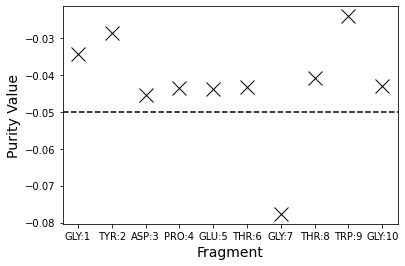

In [28]:
#@title
p = tool.run_compute_purity(psys, plog)

fig, axs = plt.subplots()
axs.plot(list(p.values()), 'kx', markersize=14)
axs.set_ylabel("Purity Value", fontsize=14)
axs.set_xticks(range(len(p)))
axs.set_xticklabels(list(p))
axs.set_xlabel("Fragment", fontsize=14)
_ = axs.axhline(-0.05, linestyle='--', color='k')

# Answer: everything seems good except Glycine.

**Exercise 2:** Using the purity value as a guide, construct your own fragmentation of the protein.

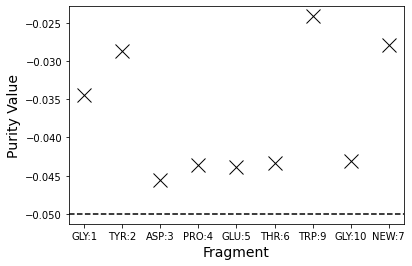

In [29]:
#@title
from copy import deepcopy
rsys = deepcopy(psys)
rsys["NEW:7"] = rsys.pop("GLY:7") + rsys.pop("THR:8")

p = tool.run_compute_purity(rsys, plog)

fig, axs = plt.subplots()
axs.plot(list(p.values()), 'kx', markersize=14)
axs.set_ylabel("Purity Value", fontsize=14)
axs.set_xticks(range(len(p)))
axs.set_xticklabels(list(p))
axs.set_xlabel("Fragment", fontsize=14)
_ = axs.axhline(-0.05, linestyle='--', color='k')

# Answer: potentially merge Glycine with something else.

**Exercise 3**: Partition the protein into its backbones and side chains. What are the strongest interacting side chains?
Hint: use the names of the amino acids. The backbone heavy atoms are: "N", "CA", "C", "O", and atom names are stored inside the atom datatype.

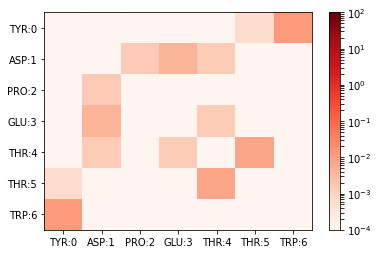

In [ ]:
#@title
from BigDFT.Fragments import Fragment
split_sys = System()
i = 0
for fragid, frag in psys.items():
    fname, _ = fragid.split(":")
    if fname == "GLY":
        continue
    split_sys[fname + ":" + str(i)] = Fragment()
    for at in frag:
        if at["name"] not in ["N", "CA", "C", "O", "H", "HN", "OXT",
                              "H1", "H2", "H3", "HA", "HA1", "HA2", "HA3"]:
            split_sys[fname + ":" + str(i)].append(at)
    i += 1

mat = zeros((len(split_sys), len(split_sys)))
sb = tool.fragment_bond_order(split_sys, list(split_sys), list(split_sys), plog)
for f1 in split_sys:
    i = int(f1.split(":")[1])
    for f2 in split_sys:
        if f1 == f2:
            continue
        j = int(f2.split(":")[1])
        mat[i, j] = sb[f1][f2]
        
fig, axs = plt.subplots(1, 1)
im = axs.imshow(mat, norm=SymLogNorm(1e-6, vmin=1e-4, vmax=1e2, base=10),
                cmap=cm.Reds, aspect='auto') 
axs.set_xticks(range(len(split_sys)))
axs.set_xticklabels(list(split_sys))
axs.set_yticks(range(len(split_sys)))
axs.set_yticklabels(list(split_sys))
_ = fig.colorbar(im)

# Answer: the two Threonines.

## Further Reading

Theory:
* Mohr, Stephan, Michel Masella, Laura E. Ratcliff, and Luigi Genovese. "Complexity reduction in large quantum systems: fragment identification and population analysis via a local optimized minimal basis." Journal of chemical theory and computation 13, no. 9 (2017): 4079-4088.
* Dawson, William, Stephan Mohr, Laura E. Ratcliff, Takahito Nakajima, and Luigi Genovese. "Complexity reduction in density functional theory calculations of large systems: system partitioning and fragment embedding." Journal of Chemical Theory and Computation 16, no. 5 (2020): 2952-2964.

Application:
* Chan, HT Henry, Marc A. Moesser, Rebecca K. Walters, Tika R. Malla, Rebecca M. Twidale, Tobias John, Helen M. Deeks et al. "Discovery of SARS-CoV-2 M pro peptide inhibitors from modelling substrate and ligand binding." Chemical science 12, no. 41 (2021): 13686-13703.
* Zaccaria, Marco, Luigi Genovese, William Dawson, Viviana Cristiglio, Takahito Nakajima, Welkin Johnson, Michael Farzan, and Babak Momeni. "Probing the mutational landscape of the SARS-CoV-2 spike protein via quantum mechanical modeling of crystallographic structures." PNAS Nexus (2022).